In [0]:
!pip install kaggle


In [0]:
!mkdir .kaggle


In [0]:
import json
token = {"username":"mssanjay","key":"63500b560696ce791d6ad3363a760246"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!chmod 600 /content/.kaggle/kaggle.json


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json


In [0]:
!kaggle config set -n path -v{/content}


- path is now set to: {/content}


In [0]:
!kaggle datasets download -d tentotheminus9/seti-data -p/content


100% 5.25G/5.25G [01:38<00:00, 35.5MB/s]
100% 5.25G/5.25G [01:38<00:00, 57.3MB/s]


In [0]:
!unzip \*.zip

Archive:  seti-data.zip
  inflating: primary_small_v3.zip    
  inflating: primary_small.zip       


In [0]:
ls

primary_small_v3.zip  primary_small.zip  sample_data/  seti-data.zip


In [0]:
rm primary_small_v3.zip

In [0]:
ls

primary_small.zip  sample_data/  seti-data.zip


In [0]:
!unzip \*.zip

Archive:  seti-data.zip
  inflating: primary_small_v3.zip    

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [0]:
def pp(img,gray=False):
    img = cv2.resize(img, (224, 224))
    if gray:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mean = np.mean(img)
    std = np.std(img)
    imag = np.clip(img, mean-3.5*std, mean+3.5*std)
  
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel=np.ones((3, 3), dtype=np.float32))
    x = cv2.Sobel(img, cv2.CV_64F, 1, 0, 2)
    y = cv2.Sobel(img, cv2.CV_64F, 0, 1, 2)
    img = cv2.addWeighted(src1=x, alpha=0.7, src2=y, beta=0.3, gamma=0)
    img = img.reshape(224, 224, 1)
    img = img/255
    return img

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_gen=ImageDataGenerator(width_shift_range=0.01,
                                 height_shift_range=0.01,
                                 zoom_range=0.01,
                                 shear_range=0.01,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 preprocessing_function=pp,
                                 rotation_range=3.0)

In [0]:
import os
import itertools
import time
train=train_gen.flow_from_directory(directory=os.path.join("train"),target_size=(224,224),batch_size=50,color_mode="grayscale")

FileNotFoundError: ignored

In [0]:
x_test = np.empty(shape=(0,224,224,1))
y_test = np.empty(shape=(0,))

In [0]:
for c in ["brightpixel","narrowband","narrowbanddrd","noise","squarepulsednarrowband","squiggle","squigglesquarepulsednarrowband"]:
  dir = os.path.join("test", c)
  temx=[]
  temy=[]
  for idx, file in enumerate(os.listdir(dir)):
    im = cv2.imread(os.path.join(dir, file))
    im = pp(im,True)
    temx.insert(idx,im)
    temy.insert(idx,c)
  temx=np.array(temx)
  temy=np.array(temy)
  x_test=np.append(x_test,temx,axis=0)
  y_test=np.append(y_test,temy,axis=0)
    

In [0]:
x_valid = np.empty(shape=(0,224,224,1))
y_valid = np.empty(shape=(0,))

In [0]:
for c in ["brightpixel","narrowband","narrowbanddrd","noise","squarepulsednarrowband","squiggle","squigglesquarepulsednarrowband"]:
  dir = os.path.join("valid", c)
  temx=[]
  temy=[]
  for idx, file in enumerate(os.listdir(dir)):
    im = cv2.imread(os.path.join(dir, file))
    im = pp(im,True)
    temx.insert(idx,im)
    temy.insert(idx,c)
  temx=np.array(temx)
  temy=np.array(temy)
  x_valid=np.append(x_test,temx,axis=0)
  y_valid=np.append(y_test,temy,axis=0)

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

enc = LabelEncoder()
enc.fit(y_test)
enc = enc.transform(y_test)
y_test = to_categorical(enc,7)
y_test = np.argmax(y_test, axis=1)

In [0]:
enc = LabelEncoder()
enc.fit(y_valid)
enc = enc.transform(y_valid)
y_valid = to_categorical(enc,7)
#y_valid = np.argmax(y_valid, axis=1)

In [0]:
from keras.models import Sequential,Model
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.layers import Dense, LeakyReLU, Flatten, Dropout,Activation,Input,BatchNormalization,GlobalAveragePooling2D,Concatenate,concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D

In [0]:
def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
   
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    
    bn_axis = 3
   
    x = Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x

In [0]:

img_input = Input(shape=(224,224,1))
channel_axis = 3
x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
x = conv2d_bn(x, 32, 3, 3, padding='valid')
x = conv2d_bn(x, 64, 3, 3)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)



x = conv2d_bn(x, 80, 1, 1, padding='valid')
x = conv2d_bn(x, 192, 3, 3, padding='valid')
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0: 35 x 35 x 256
branch1x1 = conv2d_bn(x, 64, 1, 1)

branch5x5 = conv2d_bn(x, 48, 1, 1)
branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

branch3x3dbl = conv2d_bn(x, 64, 1, 1)
branch3x3dbl = conv2d_bn(branch3x3dbl, 128, 3, 3)
branch3x3dbl = conv2d_bn(branch3x3dbl, 256, 3, 3)

branch_pool = AveragePooling2D((3, 3),strides=(1, 1),padding='same')(x)
branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
x = concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],axis=channel_axis,name='mixed0')

    # mixed 1: 35 x 35 x 288
branch1x1 = conv2d_bn(x, 64, 1, 1)

branch5x5 = conv2d_bn(x, 48, 1, 1)
branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

branch3x3dbl = conv2d_bn(x, 64, 1, 1)
branch3x3dbl = conv2d_bn(branch3x3dbl, 512, 3, 3)

branch_pool = AveragePooling2D((3, 3),strides=(1, 1),padding='same')(x)
branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
x =concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],axis=channel_axis,name='mixed1')
    # mixed 2: 35 x 35 x 288
branch1x1 = conv2d_bn(x, 64, 1, 1)

branch5x5 = conv2d_bn(x, 48, 1, 1)
branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

branch3x3dbl = conv2d_bn(x, 64, 1, 1)
branch3x3dbl = conv2d_bn(branch3x3dbl, 128, 3, 3)

branch_pool = AveragePooling2D((3, 3),strides=(1, 1),padding='same')(x)
branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
x = concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],axis=channel_axis,name='mixed2')

    # mixed 3: 17 x 17 x 768
branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')
branch3x3dbl = conv2d_bn(x, 64, 1, 1)
branch3x3dbl = conv2d_bn(branch3x3dbl, 512, 3, 3, strides=(2, 2), padding='valid')

branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
x = concatenate([branch3x3, branch3x3dbl, branch_pool],axis=channel_axis,name='mixed3')

    # mixed 4: 17 x 17 x 768
branch1x1 = conv2d_bn(x, 192, 1, 1)

branch7x7 = conv2d_bn(x, 128, 1, 1)
branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

branch7x7dbl = conv2d_bn(x, 128, 1, 1)
branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

branch_pool = AveragePooling2D((3, 3),strides=(1, 1),padding='same')(x)
branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
x = concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],axis=channel_axis,name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
for i in range(2):
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 160, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 160, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],axis=channel_axis,name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
branch1x1 = conv2d_bn(x, 192, 1, 1)

branch7x7 = conv2d_bn(x, 192, 1, 1)
branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

branch7x7dbl = conv2d_bn(x, 192, 1, 1)
branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

branch_pool = AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
x = concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # mixed 8: 8 x 8 x 1280
branch3x3 = conv2d_bn(x, 192, 1, 1)
branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')

branch7x7x3 = conv2d_bn(x, 192, 1, 1)
branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
x = concatenate(
        [branch3x3, branch7x7x3, branch_pool],
        axis=channel_axis,
        name='mixed8')

    # mixed 9: 8 x 8 x 2048
for i in range(1):
    branch1x1 = conv2d_bn(x, 320, 1, 1)

    branch3x3 = conv2d_bn(x, 384, 1, 1)
    branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
    branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
    branch3x3 = concatenate(
            [branch3x3_1, branch3x3_2],
            axis=channel_axis,
            name='mixed9_' + str(i))

    branch3x3dbl = conv2d_bn(x, 448, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
    branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
    branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
    branch3x3dbl = concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

    branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i))
 
        # Classification block
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(7, activation='softmax', name='predictions')(x)


In [0]:
model=Model(img_input, x, name='inception_v3')
model.summary()

In [0]:
opt=Adam(lr=0.0015)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

In [0]:
his = model.fit_generator(train,epochs=50,steps_per_epoch=100,validation_data=(x_valid, y_valid),shuffle=True,verbose=1)

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

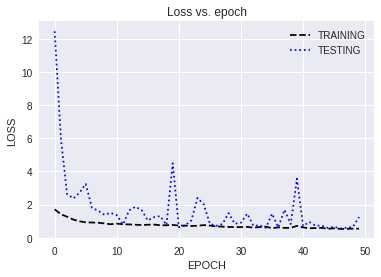

In [0]:
plt.plot(his.history['loss'],'--k')
plt.plot(his.history['val_loss'],':b')
plt.title('Loss vs. epoch')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'TESTING'], loc='best')


plt.show()

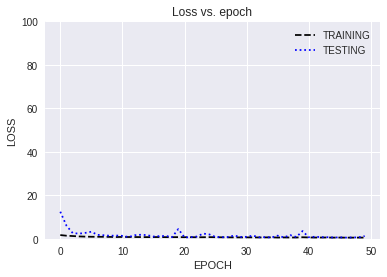

In [0]:
plt.plot(his.history['loss'],'--k')
plt.plot(his.history['val_loss'],':b')
plt.title('Loss vs. epoch')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'TESTING'], loc='best')
axes = plt.gca()
axes.set_ylim([0,100])

plt.show()

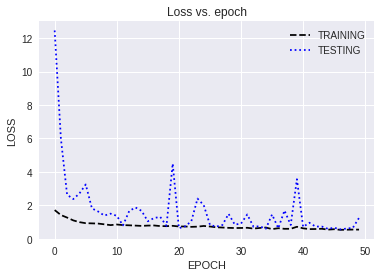

In [0]:
plt.plot(his.history['loss'],'--k')
plt.plot(his.history['val_loss'],':b')
plt.title('Loss vs. epoch')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'TESTING'], loc='best')
axes = plt.gca()
axes.set_ylim([0,13])

plt.show()

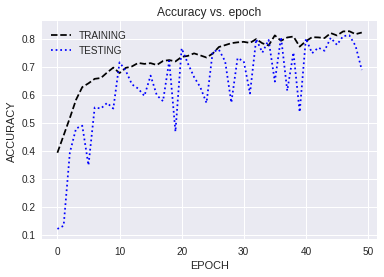

In [0]:
plt.plot(his.history['acc'],'--k')
plt.plot(his.history['val_acc'],':b')
plt.title('Accuracy vs. epoch')
plt.ylabel('ACCURACY')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'TESTING'], loc='best')

plt.show()

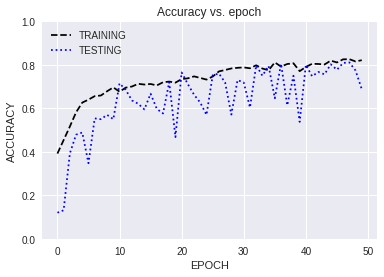

In [0]:
plt.plot(his.history['acc'],'--k')
plt.plot(his.history['val_acc'],':b')
plt.title('Accuracy vs. epoch')
plt.ylabel('ACCURACY')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'TESTING'], loc='best')
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

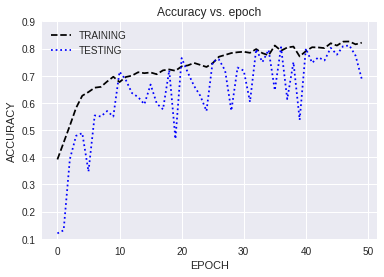

In [0]:
plt.plot(his.history['acc'],'--k')
plt.plot(his.history['val_acc'],':b')
plt.title('Accuracy vs. epoch')
plt.ylabel('ACCURACY')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'TESTING'], loc='best')
axes = plt.gca()
axes.set_ylim([0.1,0.9])
plt.show()

In [0]:
from keras.models import load_model
model.save('inceptionnet.h5')
model = load_model('inceptionnet.h5')
from google.colab import files
files.download('inceptionnet.h5') 

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 52912, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
import pickle

f = open('his_inc.pckl', 'wb')
pickle.dump(his, f)
f.close()

f = open('his_inc.pckl', 'rb')
his = pickle.load(f)
f.close()

files.download('his_inc.pckl') 

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 36496, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
#y_hat = model.predict_classes(x_test)


In [0]:
y_hat = model.predict(x_test)

In [0]:
y_hat=np.argmax(y_hat,axis=1)

In [0]:
print("Classification Report")
print(classification_report(y_test, y_hat, digits=5))

Classification Report
              precision    recall  f1-score   support

           0    0.73636   0.81000   0.77143       100
           1    0.69231   0.45000   0.54545       100
           2    0.90385   0.47000   0.61842       100
           3    0.68224   0.73000   0.70531       100
           4    0.91429   0.32000   0.47407       100
           5    0.51053   0.97000   0.66897       100
           6    0.63830   0.90000   0.74689       100

   micro avg    0.66429   0.66429   0.66429       700
   macro avg    0.72541   0.66429   0.64722       700
weighted avg    0.72541   0.66429   0.64722       700



In [0]:
print("ACCURACY:",(accuracy_score(y_test, y_hat)))

ACCURACY: 0.6642857142857143
